In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sys
import matplotlib.pyplot as plt
from textwrap import wrap
from math import pi

In [2]:
def gaussian_fit(x):
    """Given a parton jet pt (x), return g(y | x) ie the conditional density
    of the reco jet pt (y) given x. 

    The hardcoded values came from doing linear fits on the mean of g(y|x) and 
    the square root of the stdDev of g(y|x), see the notebook "DensityEstimation.ipynb"
    to see where these values came from.

    Args:
        x ([type]): [description]
    """
    SLOPE_mean = 0.90923223
    INTERCEPT_mean = 1.650221590
    SLOPE_stdDev = 0.01101888
    INTERCEPT_stdDev = 2.92408837
    mean = SLOPE_mean*x + INTERCEPT_mean
    stdDev = (SLOPE_stdDev*x + INTERCEPT_stdDev)**2

    return mean, stdDev


def scale_classifier_data(data):
    data[:, 0] = (1/data[:, 0])
    data[:, 1] = (1/data[:, 1])
    return data


def load_classifier_data(data_path):
    #TODO: Explain what this is doing
    """[summary]

    Args:
        data_path ([type]): [description]

    Returns:
        [type]: [description]
    """
    data = np.loadtxt(data_path, skiprows=2, dtype=np.float32)
    split = int(0.8*len(data))
    partonPt = data[:split, 0:1]
    recoPt = data[:split, 4:5]
    half = int(len(partonPt)/2)
    T1_partonPt = partonPt[:half, :]
    T1_recoPt = recoPt[:half, :]
    T1_labels = np.ones((T1_partonPt.shape), dtype=np.float32)
    T1 = np.concatenate((T1_partonPt, T1_recoPt, T1_labels), axis=1)
    T0_partonPt = partonPt[half:, :]
    mean, stdDev = gaussian_fit(T0_partonPt)
    T0_recoPt = np.random.normal(loc=mean, scale=stdDev)
    T0_labels = np.zeros((T0_partonPt.shape), dtype=np.float32)
    T0 = np.concatenate((T0_partonPt, T0_recoPt, T0_labels), axis=1)
    dataset = np.concatenate((T1, T0))
    np.random.shuffle(dataset)
    return scale_classifier_data(dataset)

def normPDF(x, mean, stdDev):
    return (1/(np.sqrt(2*pi*stdDev**2))) * np.exp(-0.5*((x-mean)/stdDev)**2)

In [3]:
sys.path.append('../models/Classifier/Run_2021-02-18_3/')
import classifier

In [4]:
save_dir = '../models/Classifier/Run_2021-02-18_3/'
losses = np.loadtxt(save_dir+"losses.txt", skiprows=1)

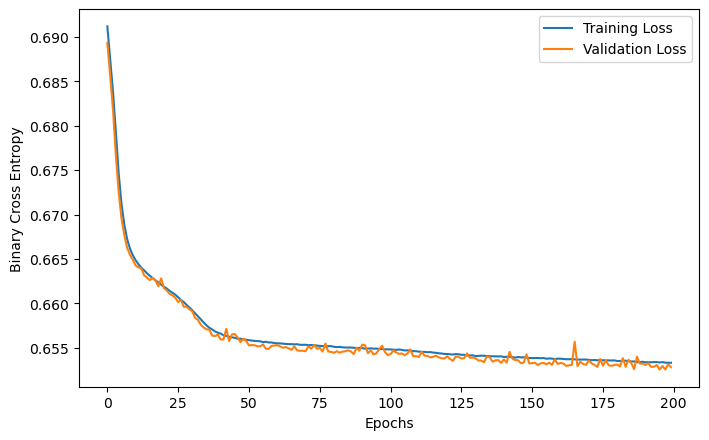

In [5]:
fig = plt.figure(figsize=(8,5), dpi=100)
ax = fig.add_subplot(111)
ax.plot(losses[:, 1], label='Training Loss')
ax.plot(losses[:, 2], label='Validation Loss')
ax.set_ylabel("Binary Cross Entropy")
ax.set_xlabel("Epochs")
#ax.set_ylim(0.0, 0.5)
ax.legend()
plt.show()

In [6]:
model = classifier.build_model()

In [7]:
model.load_weights(save_dir + '/training/cp.cpkt')

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
    )

In [15]:
data = np.loadtxt('../data/processed/newPartonMatchedJetsNoRecoPtCut.txt', skiprows=2)
dataset = load_classifier_data('../data/processed/newPartonMatchedJetsNoRecoPtCut.txt')

In [16]:
prediction = model.predict(dataset[:, :2])

In [17]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(dataset[:, 2], prediction)
m.result().numpy()

0.6005732

In [18]:
def conditional_density(partonPt, recoPts):
    recoPts = np.sort(recoPts, axis=0)
    y = np.ones((recoPts.shape))*partonPt
    model_input = np.concatenate((1/y, 1/recoPts), axis=1)
    model_output = model.predict(model_input)
    mean, stdDev = gaussian_fit(partonPt)
    values = normPDF(recoPts, mean, stdDev)
    #print(model_output.shape)
    #print(samples.shape)
    return (model_output/(1-model_output)) * values, values

In [19]:
def sample_density(partonPt, recoPts):
    recoPts = np.sort(recoPts, axis=0)
    y = np.ones((recoPts.shape))*partonPt
    model_input = np.concatenate((1/y, 1/recoPts), axis=1)
    model_output = model.predict(model_input)
    mean, stdDev = gaussian_fit(partonPt)
    samples = np.random.normal(mean, stdDev, size=(model_output.shape))
    return (model_output/(1-model_output)) * samples

(9275, 1)


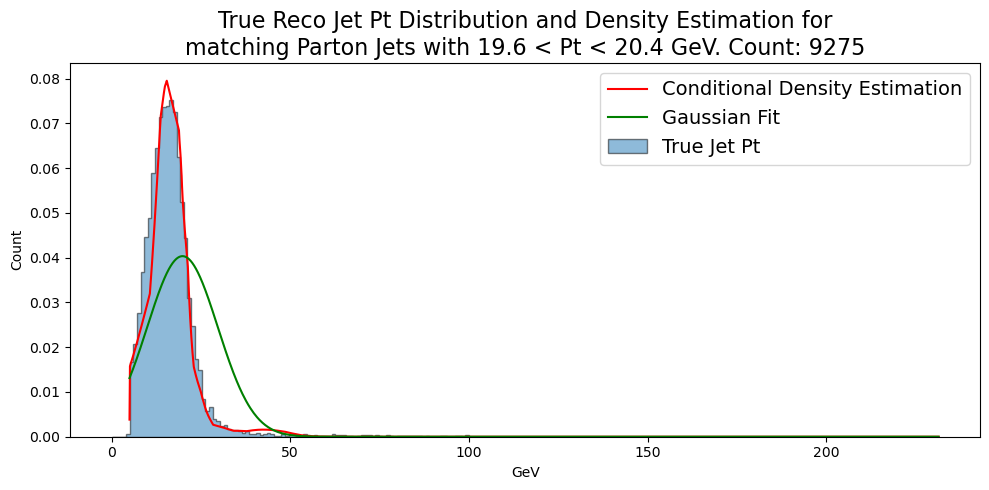

(20522, 1)


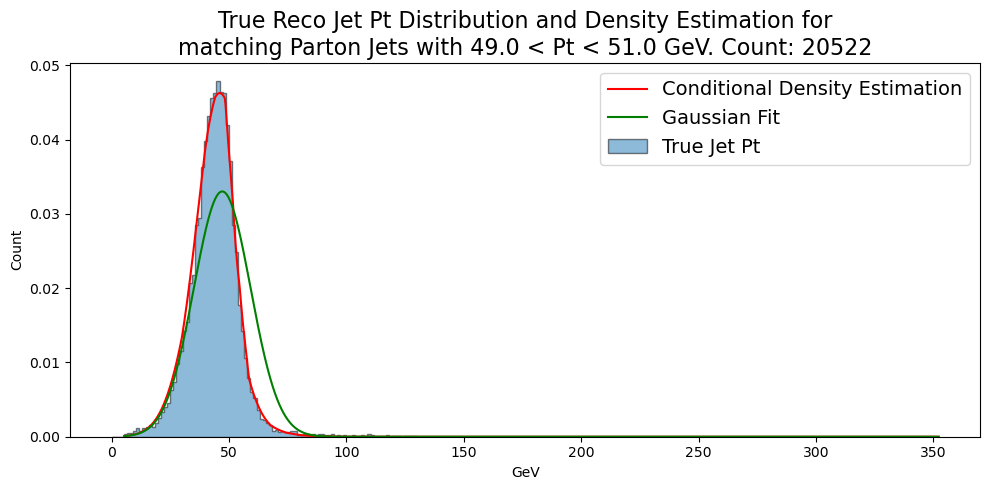

(18903, 1)


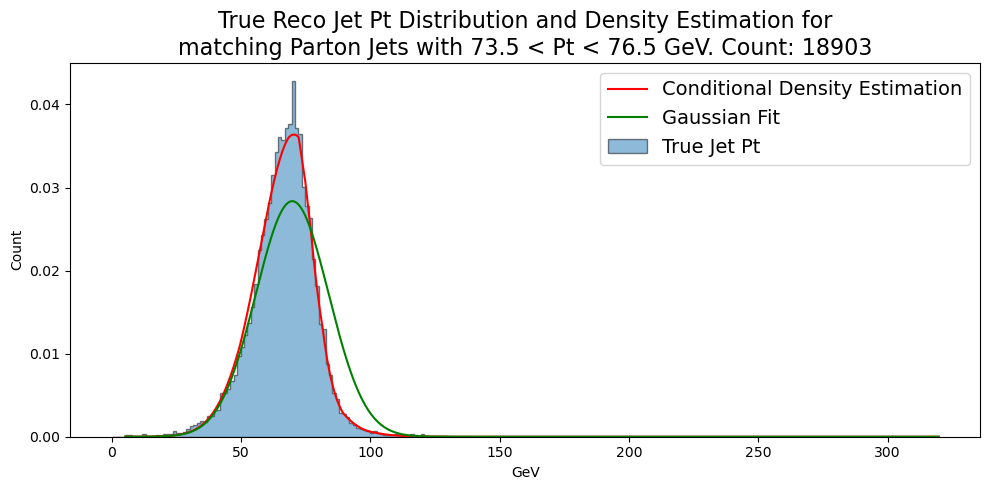

(14657, 1)


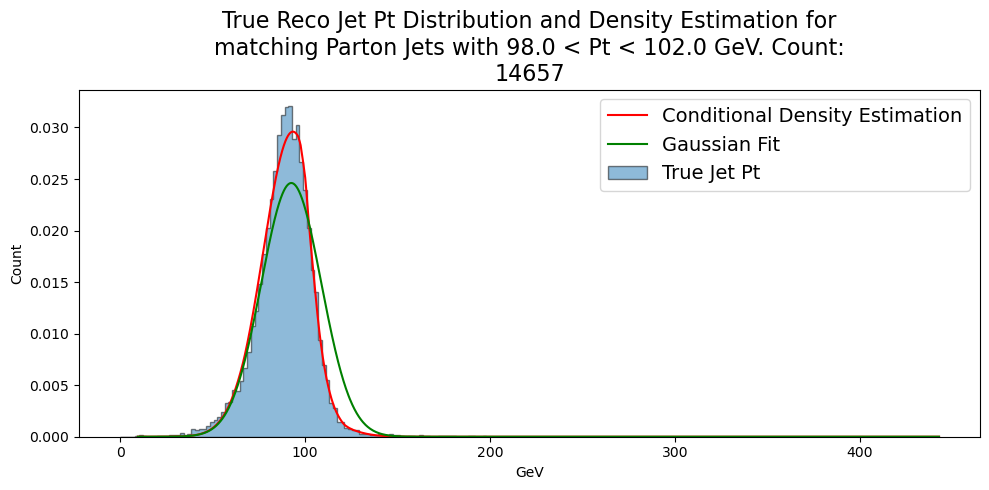

(10061, 1)


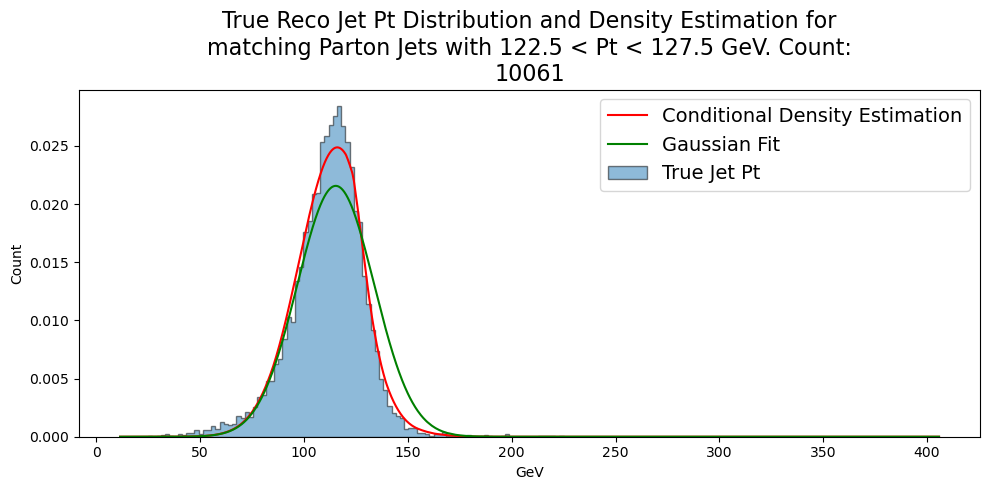

(6653, 1)


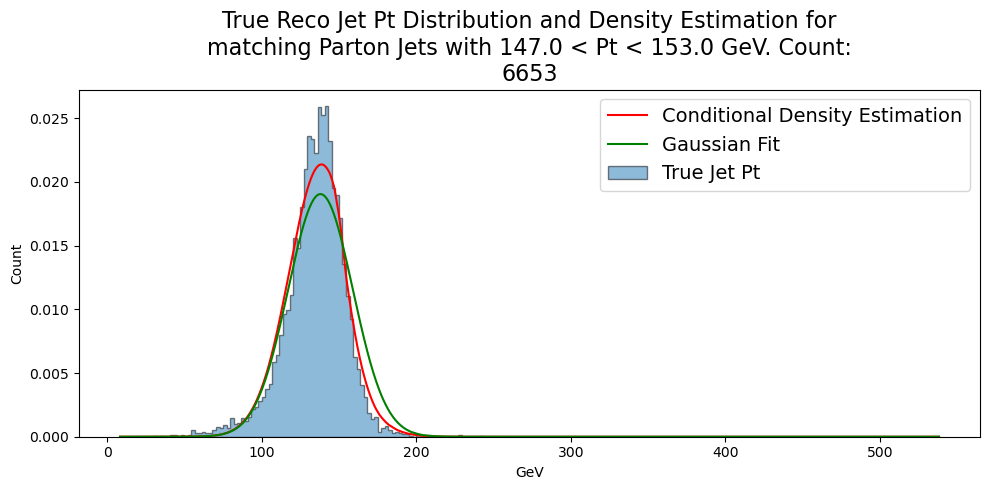

(2741, 1)


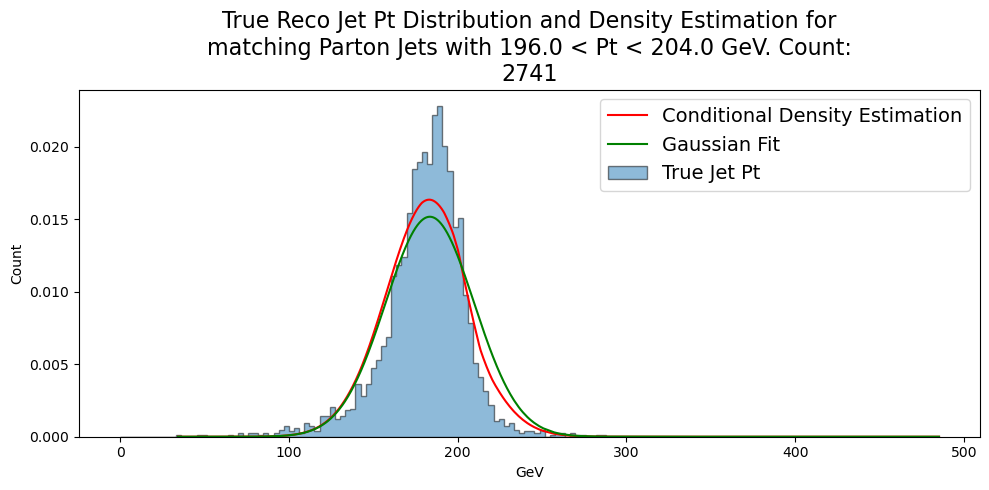

(1302, 1)


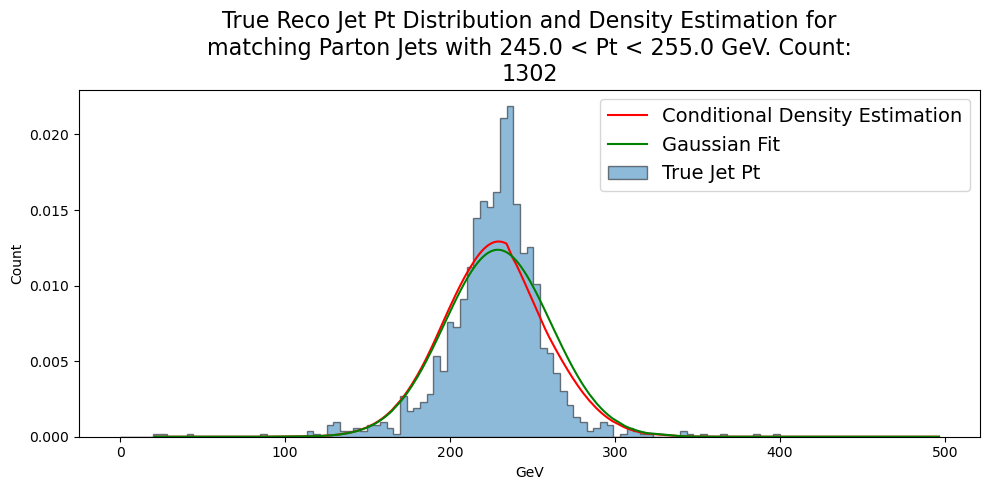

(683, 1)


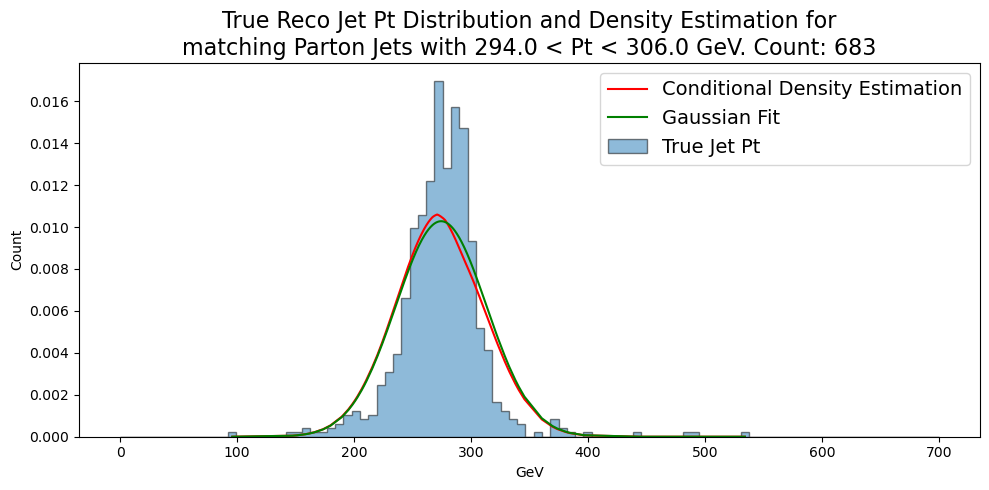

(81, 1)


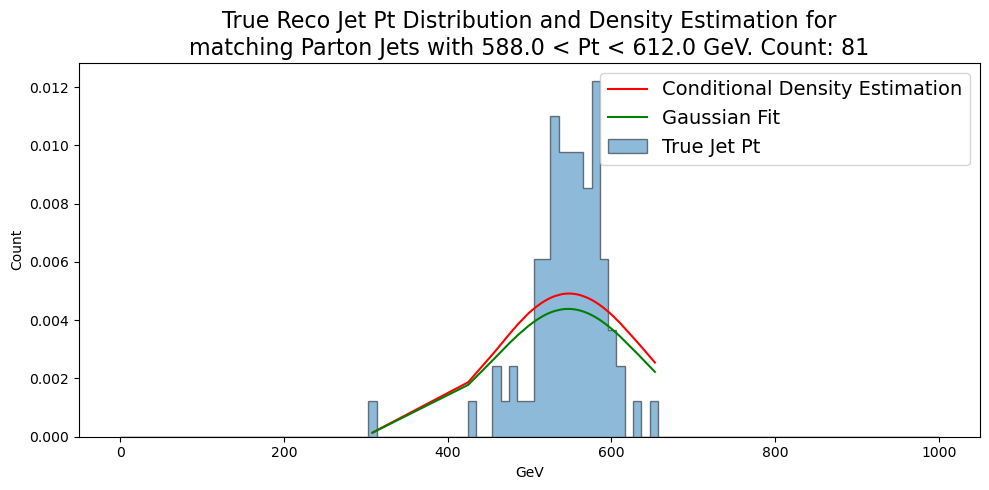

In [24]:
range_highs = [100, 130, 130, 200, 225, 250, 300, 400, 700, 1000]
range_lows = [0, 0, 0, 0, 25, 25, 0, 0, 0, 0]
j = 0
means = []
stdDevs = []
pt = []
for center in [20, 50, 75, 100, 125, 150, 200, 250, 300, 600]:        
    recoPt = []
    low = center - center/50
    high = center + center/50
    for i in range(len(data)):
        if (data[i, 0] > low and data[i, 0] < high):
            recoPt.append(data[i, 4])
    recoPt = np.expand_dims(np.array(recoPt), axis=1)
    altered_density, density = conditional_density(center, recoPt)
    samples = sample_density(center, recoPt)
    print(density.shape)
    fig = plt.figure(figsize=(10,5), dpi=100)
    ax = fig.add_subplot(111)
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    ax.hist(recoPt, density=True, bins=bins, label='True Jet Pt', alpha=0.5, ec="k", histtype='stepfilled')
    #ax.hist(samples, density=True, bins=bins, label='Samples from Cond. Estimation', ec='b', histtype='step')
    ax.plot(np.sort(recoPt, axis=0), altered_density, label='Conditional Density Estimation', c='r')
    ax.plot(np.sort(recoPt, axis=0), density, label='Gaussian Fit', c='g')
    ax.set_xlabel("GeV")
    ax.set_ylabel("Count")
    ax.set_title("\n".join(wrap("True Reco Jet Pt Distribution and Density Estimation for matching Parton Jets with {} < Pt < {} GeV. Count: {}".format(low, high, len(recoPt)), width=60)), fontsize=16)

    ax.legend(fontsize=14)
    plt.tight_layout()
    plt.show()
    #fig.savefig(save_dir+"/PtDistLog{}.png".format(j), facecolor="white", transparent="True")
    j+=1